## Symantic Spotter: Build a RAG System using LlamaIndex







 #### Option  1: Insurance domain + Build the rag pipeline using llamaindex.


```
### Here are Step by Step Details for Building a RAG system using LlamaIndex
```


### Why RAG ?

#### Part 0 - RAG Architecture.


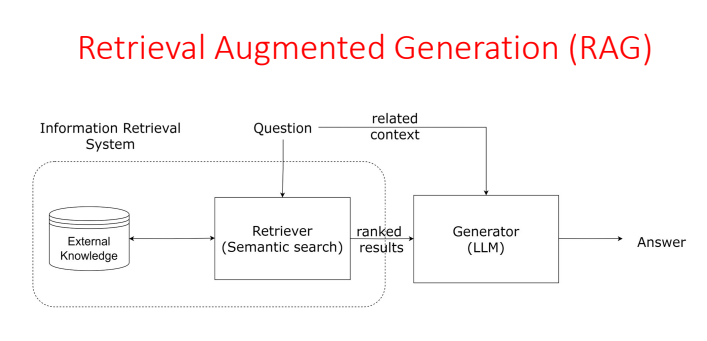

Without RAG: LLM's don't have any information on the domain/enterprise specific query.



Using  RAG We are can connect an external data ingested & transformed embeddings into vectorDB. We can peform Semantic search or say dot product or cosine similarity and return  top k relevant documents. We can then pass this return context along with  user query using decorated prompt engineering to llm to repspond to user query from domain specific docs say here insurance documents.

 RAG also helps to cache the latest query and answer in cache. If check in similary query present in cache  if yes return from cache. If not found in cache then perform semantic search and using context check with llm for query. results in cache return from cache from save usig past coversation else perfrom sematic search search in vector with top k context generate the response usign llm.

 RAG also helps in overcoming the problem of fixed token size issues with Llm and hallucination.



### Why LlamaIndex?






LlamaIndex is an innovative data framework specially designed to support LLM-based RAG framework application development. It offers an advanced framework that empowers developers to integrate diverse data sources with large language models.

LlamaIndex includes a variety of file formats, such as PDFs and PowerPoints, as well as applications like Notion and Slack and even databases like Postgres and MongoDB.

The framework brings an array of connectors that assist in data ingestion, facilitating a seamless interaction with LLMs. Moreover, LlamaIndex boasts an efficient data retrieval and query interface.

LlamaIndex enables developers to input any LLM prompt and, in return, receive an output that is both context-rich and knowledge-augmementation.
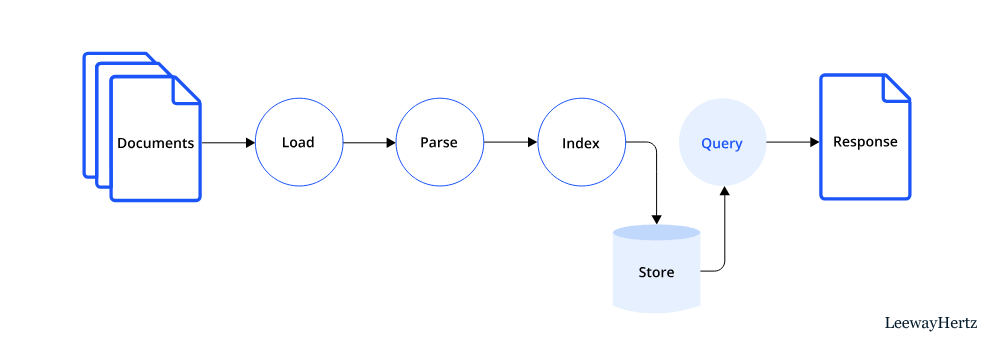


#### key Feature of LlamaIndex:
*   Data connectors allow ingestion from various data sources and formats.

*   It can synthesize data from multiple documents or heterogeneous data sources.
* It provides numerous integrations with vector stores, ChatGPT plugins, tracing tools, LangChain, and more.





### Part 1 - Overall Product Specifications

***Problem Statement*** - Build a robust generative search system capable of effectively and accurately answering questions from a list of HDFC Insurance policy documents.

***Solution Strategy*** - Build a solution which should solve the following requirements:

- Users would responses from insurance policy knowledge base.
- If user want to perform a query system must be able to response to query accurately.

***Goal*** - Solving the above two requirements well in and would ensure that the accuracy of the overall model is good.

***Data Used*** -HDFC Insuracne policy documetns sotred in single folder

***Tools used*** - LlamaIndex, GhatGPT has been used due to its powerful query engine, fast data processing using data loaders and directory readers as well as easier and faster implementation using fewer lines of code.

### Part 2 - Proposed Solution

In this section, we go ahead and actually build the solution that we proposed in the previous step using Llamindex. Here is the architecture.

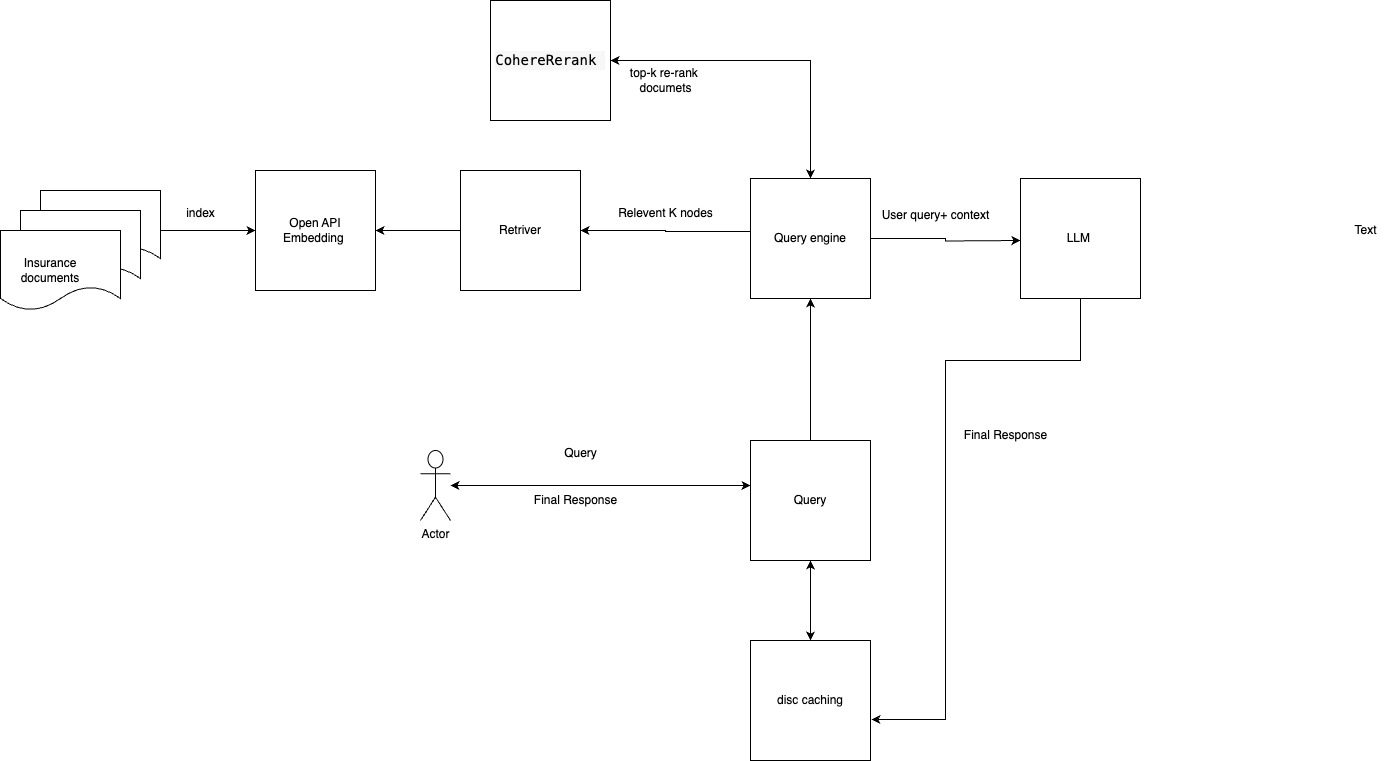

#####  Discriptions about the Architecture:


1. *Documents*: We will be using list of HDFC insurance documents provides inside a single folder.

2. *Open API embedding*: We ars using OpenAPI embedding as Vector DB for indexing insureance documetns in the form of embedding.

3. *Query Engine*: We are using Query Engine Module of Llammaindex for perfomring synantic Search. Query Engine will use internally Retriver and Cohere Rerank to retrrive top-k relvent nodes from embedding.

4. *LLM* : top k-documets  along with usewr query will be passed to LLM to generate the accurate response.

5. *Caching*:" Caching is being used to improve the read operation. Recent similar search will be store in Caching and user query frist will be served from Cahcing. If user query not found in cahce then query will be  forwared to query engine and then LLM to geneate the resposne. user query and generated resposne will be cached in in cache and will be served from there based ttl.

6. *Meta data*:Along with Resposne we are also returning docs referece and similary score to improve the user confidence towards the implemented RAG system.

7. *Cohere-Rerank*: Is being used to rerank the query based on semantic score.






*Step* 1  : Import the necessary libraries







In [7]:
#Load llamaindex
!pip install llama-index

In [8]:
#Loading docx2txt for document reading related dependencies
!pip install docx2txt

In [9]:
!pip install pypdf

In [10]:
!pip install openai

In [11]:
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
import os
import openai

Step 2 : Mount your Google Drive and Set the API key

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Set the API key
keypath = "/content/drive/My Drive/GEN AI/RAG/"

with open(keypath + "open_ai.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines()).replace('\ufeff','')


In [14]:
from google.colab import userdata
cohere_api_key = userdata.get('cohere_key')

Step 3 - Data Loading


***2 ways to do this***

- If you have a single file containing all the required data, use a data loader from [LLamahub](https://llamahub.ai/)

- If you have multiple files, use *Simple Directory Reader* Just ensure that for reading each file type the necessary dependency libraries are already installed.

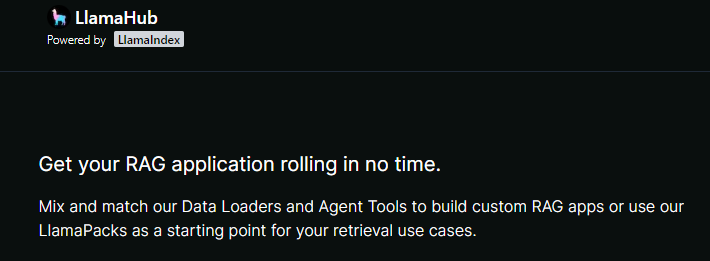

Recommendation - No matter how powerful the given data loader is, ensure that your file is properly formatted, and the loader is able to read the file clearly. Else the query engine might fail

In [15]:
# reading the multiple files for insurance data.
from llama_index.core import SimpleDirectoryReader, ServiceContext, VectorStoreIndex
reader = SimpleDirectoryReader(input_dir="/content/drive/My Drive/GEN AI/Semantic_Spotter_Assignment/data/")

In [16]:
documents = reader.load_data()
print(f"Loaded {len(documents)} docs")

Loaded 121 docs


In [17]:
documents

[Document(id_='2cfd420a-df01-4652-87ed-2c61691c57db', embedding=None, metadata={'page_label': '1', 'file_name': 'Copy of HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_path': '/content/drive/My Drive/GEN AI/Semantic_Spotter_Assignment/data/Copy of HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_type': 'application/pdf', 'file_size': 1303156, 'creation_date': '2024-07-20', 'last_modified_date': '2024-07-20'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=' \n             Part A \n<<Date>> \n<<Policyholder’s Name>>  \n<<Policyholder’s Address>> \n<<Policyholder’s Contact Number>>  \n \nDear <<Policyholder’s Name>>,  \n \nSub: Your Policy no. <<  >> \nWe are glad to inform you that your proposal has been accepted an

In [18]:

%pip install llama-index-llms-openai
!pip install llama-index

Step 4 - Building the query engine

In [19]:
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core.indices.vector_store.base import VectorStoreIndex
#from llama_index import VectorStoreIndex
from IPython.display import display, HTML


# # build index
index = VectorStoreIndex(documents)

# Construct Query Engine
query_engine = index.as_query_engine()

Step 5 - Checking respones and respone parameters

In [20]:
response = query_engine.query("what will happen if If Nominee(s) die after the Policyholder but before his share of the amount secured under the Policy is paid?")

In [21]:
#Checking the response
response.response

'The share of the expired Nominee(s) shall be payable to the heirs or legal representative of the Nominee or holder of succession certificate of such Nominee(s).'

In [22]:
#Check the source node
response.source_nodes

[NodeWithScore(node=Document(id_='d06e7ee9-521e-4216-9dee-0b3cbcedf8f0', embedding=None, metadata={'page_label': '29', 'file_name': 'Copy of HDFC-Life-Group-Term-Life-Policy.pdf', 'file_path': '/content/drive/My Drive/GEN AI/Semantic_Spotter_Assignment/data/Copy of HDFC-Life-Group-Term-Life-Policy.pdf', 'file_type': 'application/pdf', 'file_size': 874679, 'creation_date': '2024-07-20', 'last_modified_date': '2024-07-20'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=' \nF&U dated 15th October  2022                  UIN-101N169V0 2  P a g e  | 28                        \n ANNEXURE - C \nSection 39 – Nomination by Policyholder  \n \nProvisions regarding nomination of a Policy  in terms of Section 39 of the Insurance Act, 1938, as amended from \ntime to t

In [23]:
#Extract the file name
response.source_nodes[0].node.metadata['file_name']

'Copy of HDFC-Life-Group-Term-Life-Policy.pdf'

In [24]:
#Extract the score
response.source_nodes[1].score

0.8506074485595169

In [25]:
# install lib for query-re-ranking to return better results
!pip install llama-index-postprocessor-cohere-rerank

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.4 MB/s eta 0:00:00


In [26]:
# customizing the prompts.
from llama_index.core import PromptTemplate

text_qa_template_str = (
    "Context information is"
    " below.\n---------------------\n{context_str}\n---------------------\nUsing"
    " both the context information and also using your own knowledge, answer"
    " the question: {query_str}\nIf the context isn't helpful, you can also"
    " answer the question on your own.\n"
)
text_qa_template = PromptTemplate(text_qa_template_str)


refine_template_str = (
    "The original question is as follows: {query_str}\nWe have provided an"
    " existing answer: {existing_answer}\nWe have the opportunity to refine"
    " the existing answer (only if needed) with some more context"
    " below.\n------------\n{context_msg}\n------------\nUsing both the new"
    " context and your own knowledge, update or repeat the existing answer.\n"
)
refine_template = PromptTemplate(refine_template_str)


Step 6 - Creating a response Pipeline

User receives the response and the document that they can refer to

In [27]:
#Definig the query engine with query re-ranking and top_n, with Custom promting which helps RAG system return accurate information.


In [28]:
# deinfing ll
llm = OpenAI(model="gpt-3.5-turbo")
import os
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core.postprocessor import SimilarityPostprocessor

cohere_rerank = CohereRerank(api_key=cohere_api_key, top_n=3)
response=index.as_query_engine(
        similarity_top_k=3,
        node_postprocessors=[cohere_rerank],
        text_qa_template=text_qa_template,
        refine_template=refine_template,
        llm=llm
)

In [29]:
def initialize_conv():
  print('Feel free to ask Questions regarding HDFC insurance.Press exit once you are done')
  while True:
    user_input = input()
    if user_input.lower() == 'exit':
      print('Exiting the program... bye')
      break
    else:
      response = query_response(user_input)
      display(HTML(f'<p style="font-size:20px">{response}</p>'))

Step 7 - Build a Testing Pipeline

Here we feed a series of questions to the Q/A bot and store the responses along with the feedback on whether it's accurate or not from the user

In [30]:
# Definig the user query.
questions = ['what is beneficiary in HDFC insurance policy', 'Which is company name is talking about in provided context?',' who is eligible member in the context of insurance policy?',
             'when a person can recieve the claims?']


In [31]:
!pip install diskcache
import openai
import diskcache as dc

cache = dc.Cache('./gpt_cache')





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.6 MB/s eta 0:00:00


In [32]:
cache.set("A", "answer")


True

In [33]:
print(cache.get("A"))

answer


In [34]:
def query_response(user_input):
    final_response=""
    cache_response=None
    cache_response=cache.get(user_input)
    if cache_response is None:
      response=query_engine.query(user_input)
      print("Answer from LLM:\n")
      file_name = response.source_nodes[0].node.metadata['file_name']
      response = response.response + '\nCheck further at ' + file_name + ' for document references.'+'\nSimilarity score is :' + str(response.source_nodes[1].score)
      cache.set(user_input, response)
      final_response=response
    else:
      print("Answer  from cache:\n")
      final_response=cache_response

    return final_response




In [35]:
print(query_response("when a person can recieve the claims"))


Answer from LLM:

A person can receive the claims after submitting all necessary claim documents within 60 days from the date of diagnosis of the condition. However, the delay in claim intimation may be condoned if valid reasons are provided for the delay.
Check further at Copy of HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf for document references.
Similarity score is :0.8081550073424348


In [36]:
def testing_pipeline(questions):
  test_feedback  = []
  for i in questions:
    print(i)
    print(query_response(i))
    print('\n Please provide your feedback on the response provided by the bot')
    user_input = input()
    test_feedback.append((i,query_response(i),user_input))
  feedback_df = pd.DataFrame(test_feedback, columns =['Question', 'Response', 'Good or Bad'])
  return feedback_df

In [37]:
import pandas as pd

In [38]:
testing_pipeline(questions)

what is beneficiary in HDFC insurance policy
Answer from LLM:

The beneficiary in HDFC insurance policy is the individual or entity designated by the insured member to receive the benefits under the policy in the event of the insured member's death.
Check further at Copy of HDFC-Life-Group-Term-Life-Policy.pdf for document references.
Similarity score is :0.8327875397728577

 Please provide your feedback on the response provided by the bot
good
Answer  from cache:

Which is company name is talking about in provided context?
Answer from LLM:

HDFC Life
Check further at Copy of HDFC-Life-Group-Term-Life-Policy.pdf for document references.
Similarity score is :0.7607341495571885

 Please provide your feedback on the response provided by the bot
goos
Answer  from cache:

 who is eligible member in the context of insurance policy?
Answer from LLM:

An eligible member in the context of the insurance policy is a person who satisfies the eligibility criteria mentioned in the policy and is aged

,Question,Response,Good or Bad
0,what is beneficiary in HDFC insurance policy,The beneficiary in HDFC insurance policy is th...,good
1,Which is company name is talking about in prov...,HDFC Life\nCheck further at Copy of HDFC-Life-...,goos
2,who is eligible member in the context of insu...,An eligible member in the context of the insur...,good
3,when a person can recieve the claims?,A person can receive the claims after submitti...,good


In [39]:
print(query_response("what is beneficiary in HDFC insurance policy?"))


Answer from LLM:

The beneficiary in HDFC insurance policy is the individual or entity designated by the insured member to receive the benefits under the policy in the event of the insured member's death.
Check further at Copy of HDFC-Life-Group-Term-Life-Policy.pdf for document references.
Similarity score is :0.84421738104293


### Chalenges Faced:
We tried to use GPTCache with for caching system,but due compatiability issues. We couldn't interate it.
### Alnative Solution:
We are usign disc caching for alternative to GPTCache.